In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
from utils import plot_spk_rec, plot_mem_rec, generate_random_silence_files
from scnn import SNN
from scnn.optim import RAdam

from data.data_augmentor import data_augment, batchify
from tools.time_expector import TimeExpector
time_expector = TimeExpector()

In [3]:
batch_size = 4
nb_epochs = 6

device = torch.device('cpu')#"cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float

test_run = True
if test_run:
    print('[WARNING] : This is test run.')

[WARNING] : This is test run.


In [4]:
# FIXME
my_laptop = False
if my_laptop:
    CACHE_FOLDER_PATH = "/Users/aref/dvs-dataset/Cached"
    DATASET_FOLDER_PATH = "/Users/aref/dvs-dataset/DvsGesture"
else:
    CACHE_FOLDER_PATH = "/home/aref/dataset/dvs-dataset"
    DATASET_FOLDER_PATH = "/home/aref/dataset/dvs-dataset"

    
def load_data(trail):
    if test_run:
        trail = 'acc_test' # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< Remove this >>>>>>>>>>>>>>>>
    
    if trail.startswith('acc'):
        max_augmentation = 1
        augmentation = False
    else:
        max_augmentation = 3 if trail == 'train' else 1
        augmentation = True
    
    trail = trail.replace('acc_', '')
    return batchify(
        trail,
        DATASET_FOLDER_PATH,
        CACHE_FOLDER_PATH,
        condition_limit=['natural'],
        batch_size=batch_size,
        augmentation=augmentation,
        max_augmentation=max_augmentation,
        frame=60
    )

# calculate train dataset size
dataset_size = [0., 0.]
for x_batch, y_batch in load_data('train'):
    dataset_size[0] += 1.
    if dataset_size[0] % 64 == 1:
        print('\rpre-processing dataset: %d' % dataset_size[0], end='')
print('\rpre-processing dataset: %d' % dataset_size[0])
for x_batch, y_batch in load_data('test'):
    dataset_size[1] += 1.
    if dataset_size[1] % 64 == 1:
        print('\rpre-processing dataset: %d' % dataset_size[1], end='')
print('\rpre-processing dataset: %d' % dataset_size[1])

pre-processing dataset: 175
pre-processing dataset: 175


In [5]:
%matplotlib inline

from matplotlib.gridspec import GridSpec

def plot_spikes_in_time(layer, batch_id=0):
    if layer.IS_CONV:
        _plot_spikes_conv(layer, batch_id)
    else:
        _plot_spikes_dense(layer, batch_id)


def _plot_spikes_dense(layer, batch_id=0):
    spk_rec_hist = layer.spk_rec_hist[batch_id]
    mem_rec_hist = layer.mem_rec_hist[batch_id]
    
    for i in range(mem_rec_hist.shape[1]):
        plt.plot(mem_rec_hist[:, i], label='mem')
    plt.xlabel('Time')
    plt.ylabel('Membrace Potential')
    
    plt.show()
    plt.plot(spk_rec_hist,'b.')
    plt.xlabel('Time')
    plt.ylabel('Spikes')
    plt.show()
    
    plt.matshow(spk_rec_hist)
    plt.xlabel('Neuron')
    plt.ylabel('Spike Time')
    plt.axis([-1, spk_rec_hist.shape[1], -1, spk_rec_hist.shape[0]])
    plt.show()
    

def _plot_spikes_conv(layer, batch_id=0):
    spk_rec_hist = layer.spk_rec_hist[batch_id]
    mem_rec_hist = layer.mem_rec_hist[batch_id]
    
    time_step = mem_rec_hist.shape[1]
    channels = mem_rec_hist.shape[0]
    rest_shape = mem_rec_hist.shape[2:]
    
    tmp_spk = np.zeros((time_step, channels, *rest_shape))
    tmp_mem = np.zeros((time_step, channels, *rest_shape))
    for i in range(time_step):
        tmp_spk[i, :, :, :] = spk_rec_hist[:, i, :, :]
        tmp_mem[i, :, :, :] = mem_rec_hist[:, i, :, :]
    spk_rec_hist = tmp_spk
    mem_rec_hist = tmp_mem
    
    flat_spk = np.reshape(spk_rec_hist, (time_step, channels*np.prod(mem_rec_hist.shape[2:])))
    flat_mem = np.reshape(mem_rec_hist, (time_step, channels*np.prod(mem_rec_hist.shape[2:])))
    
    # Plot Flats
    max_flats = 25
    if flat_mem.shape[1] > max_flats:
        inx = np.random.randint(flat_mem.shape[1], size=max_flats)
        flat_spk = flat_spk[:, inx]
        flat_mem = flat_mem[:, inx]
    
    for i in range(flat_mem.shape[1]):
        plt.plot(flat_mem[:, i], label='mem')
    plt.xlabel('Time')
    plt.ylabel('Membrace Potential')
    plt.show()
    
    plt.plot(flat_spk,'.')
    plt.xlabel('Time')
    plt.ylabel('Spikes')
    plt.show()
    
    plt.matshow(flat_spk, cmap=plt.cm.gray_r, origin="lower", aspect='auto')
    plt.xlabel('Neuron')
    plt.ylabel ('Spike Time')
    plt.axis([-1, flat_spk.shape[1], -1, flat_spk.shape[0]])
    plt.show()
    
    # Visual Plots
    max_visual = 5
    
#     debug_print(spk_rec_hist, 'spk', pytorch=False)
#     debug_print(mem_rec_hist, 'mem', pytorch=False)

    time_idx = list(range(0, time_step, int(time_step/max_visual)))
    neur_idx = np.random.randint(mem_rec_hist.shape[1], size=max_visual)

    gs = GridSpec(max_visual, max_visual)
    plt.figure(figsize=(30, 20))

#     counter = 0
#     for n in neur_idx:
#         for t in time_idx:
#             if counter == 0:
#                 a0 = ax = plt.subplot(gs[counter])
#             else:
#                 ax = plt.subplot(gs[counter], sharey=a0)
#             ax.imshow(spk_rec_hist[t, n, :, :], cmap=plt.cm.gray_r, origin="lower", aspect='auto')
#             plt.title('t(%d) - n(%d)' % (t, n))
#             counter += 1
#     plt.show()
    
    gs = GridSpec(max_visual, max_visual)
    plt.figure(figsize=(30, 20))

    counter = 0
    for n in neur_idx:
        for t in time_idx:
            if counter == 0:
                a0 = ax = plt.subplot(gs[counter])
            else:
                ax = plt.subplot(gs[counter], sharey=a0)
            ax.imshow(mem_rec_hist[t, n, :, :], cmap=plt.cm.gray_r, origin="lower", aspect='auto')
            plt.title('t(%d) - n(%d)' % (t, n))
            counter += 1
    plt.show()

In [6]:
from scnn.default_configs import *

class MyConv3D(torch.nn.Module):
    IS_CONV = True
    IS_SPIKING = True
    HAS_PARAM = True

    def __init__(self, input_shape, output_shape,
                 input_channels, output_channels, kernel_size, dilation,
                 spike_fn, w_init_mean=W_INIT_MEAN, w_init_std=W_INIT_STD, recurrent=False,
                 lateral_connections=True,
                 eps=EPSILON, stride=(1, 1, 1), flatten_output=False):

        super(MyConv3D, self).__init__()

        self.kernel_size = np.array(kernel_size)
        self.dilation = np.array(dilation)
        self.stride = np.array(stride)
        self.input_channels = input_channels
        self.output_channels = output_channels

        self.input_shape = input_shape
        self.output_shape = output_shape
        self.spike_fn = spike_fn
        self.recurrent = recurrent
        self.lateral_connections = lateral_connections
        self.eps = eps

        self.flatten_output = flatten_output

        self.w_init_mean = w_init_mean
        self.w_init_std = w_init_std

        self.w = torch.nn.Parameter(torch.empty((output_channels, input_channels, *kernel_size)), requires_grad=True)
        if recurrent:
            self.v = torch.nn.Parameter(torch.empty((output_channels, output_channels)), requires_grad=True)
        self.beta = torch.nn.Parameter(torch.empty(1), requires_grad=True)
        self.b = torch.nn.Parameter(torch.empty(output_channels), requires_grad=True)

        self.reset_parameters()
        self.clamp()

        self.spk_rec_hist = None
        self.mem_rec_hist = None
        self.training = True

        # TODO : check this
        tau_mem = 10e-3
        tau_syn = 5e-3
        time_step = 1e-3
        self._alpha = float(np.exp(-time_step / tau_syn))
        self._beta = float(np.exp(-time_step / tau_mem))

    def get_trainable_parameters(self):
        res = [
            {'params': self.w},  #, 'lr': lr, "weight_decay": DEFAULT_WEIGHT_DECAY}
            {'params': self.b},
            {'params': self.beta},
        ]

        if self.recurrent:
            res.append({'params': self.v})
        return res

    def forward(self, x):
        batch_size = x.shape[0]
        nb_steps = x.shape[2]
        
        stride = tuple(self.stride)
        padding = tuple(np.ceil(((self.kernel_size - 1) * self.dilation) / 2).astype(int))
        conv_x = torch.nn.functional.conv3d(x, self.w, padding=padding,
                                            dilation=tuple(self.dilation),
                                            stride=stride)
        conv_x = conv_x[:, :, :, :self.output_shape[0], :self.output_shape[1]]

        mem = torch.zeros((batch_size, self.output_channels, *self.output_shape), dtype=x.dtype, device=x.device)
#         syn = torch.zeros((batch_size, self.output_channels, *self.output_shape), device=x.device, dtype=x.dtype)  # FIXME
        spk = torch.zeros((batch_size, self.output_channels, *self.output_shape), dtype=x.dtype, device=x.device)

        spk_rec = torch.zeros((batch_size, self.output_channels, nb_steps, *self.output_shape), dtype=x.dtype, device=x.device)
        mem_rec = torch.zeros((batch_size, self.output_channels, nb_steps, *self.output_shape), dtype=x.dtype, device=x.device)

        if self.lateral_connections:
            d = torch.einsum("abcde, fbcde -> af", self.w, self.w)
        b = self.b.unsqueeze(1).unsqueeze(1).repeat((1, *self.output_shape))

        norm = (self.w ** 2).sum((1, 2, 3, 4))

        for t in range(nb_steps):
            # spike term
            # mthr = torch.einsum("abcd,b->abcd", mem, 1. / (norm + self.eps)) - b
            # spk = self.spike_fn(mthr)

            if self.lateral_connections:
                rst = torch.einsum("abcd,be ->aecd", spk, d)
            else:
                rst = torch.einsum("abcd,b,b->abcd", spk, self.b, norm)

            input_ = conv_x[:, :, t, :, :]
            if self.recurrent:
                input_ = input_ + torch.einsum("abcd,be->aecd", spk, self.v)

            # TODO : check to see if this is actually works
#             new_syn = self._alpha * syn + input_
#             new_mem = self._beta * mem + syn - rst
#             mem = new_mem
#             syn = new_syn
            mem = (mem - rst) * self.beta + input_ * (1. - self.beta)

            mthr = torch.einsum("abcd,b->abcd", mem, 1. / (norm + self.eps)) - b
            spk = self.spike_fn(mthr)

            spk_rec[:, :, t, :, :] = spk
            mem_rec[:, :, t, :, :] = mem

        self.spk_rec_hist = spk_rec.detach().cpu().numpy()
        self.mem_rec_hist = mem_rec.detach().cpu().numpy()

        if self.flatten_output:
            output = torch.transpose(spk_rec, 1, 2).contiguous()
            output = output.view(batch_size, nb_steps, self.output_channels * np.prod(self.output_shape))
        else:
            output = spk_rec

        return output

    def reset_parameters(self):
        torch.nn.init.normal_(self.w, mean=self.w_init_mean,
                              std=self.w_init_std * np.sqrt(1. / (self.input_channels * np.prod(self.kernel_size))))
        if self.recurrent:
            torch.nn.init.normal_(self.v, mean=self.w_init_mean,
                                  std=self.w_init_std * np.sqrt(1. / self.output_channels))
        torch.nn.init.normal_(self.beta, mean=0.7, std=0.01)
        torch.nn.init.normal_(self.b, mean=1., std=0.01)

    def clamp(self):
        self.beta.data.clamp_(0., 1.)
        self.b.data.clamp_(min=0.)




In [7]:
from scnn.legacy_dense import LegacyDense

network = SNN(device=device, dtype=dtype)
network.time_expector = time_expector


tau_mem = 10e-3
tau_syn = 5e-3
time_step = 1e-3
beta = float(np.exp(-time_step / tau_mem))
weight_scale = 7*(1.0 - beta)

# network.add_dense( #layer(LegacyDense,
#     input_shape=4096,
#     output_shape=128,              
#     w_init_mean=0.0,
#     w_init_std=weight_scale
# )

# network.add_layer(NewSpiker,
#     input_shape=4096,
#     output_shape=128,
                  
#     w_init_mean=0.0,
#     w_init_std=weight_scale
# )

network.add_layer(MyConv3D,
    input_shape=(64,64),
    output_shape=(64,64),
    input_channels=1,
    output_channels=128,
    kernel_size=(3,3,3),
    dilation=(1,1,1),
    lateral_connections=True,
    
    w_init_mean=0.2,
    w_init_std=weight_scale
)

# network.add_layer(SpikingPool2DLayer, kernel_size=(2,2), output_channels=32)
network.add_pool2d(kernel_size=(4,4), output_channels=128)


network.add_dense(
#     input_shape=4096,
    output_shape=128,
    w_init_mean=0.0,
    w_init_std=weight_scale
#     lateral_connections=True
)

# network.add_layer(SpikingDenseLayer,
#     output_shape=256
# )

# network.add_layer(SpikingDenseLayer,
#     output_shape=128,
#     w_init_mean=.19
# )

network.add_readout(output_shape=12,
                    time_reduction="max" # mean or max
)

network.compile()
network = network.to(network.device, network.dtype) # FIXME: this is a bug, fix it!

Layer 0: average number of spikes=0.0019


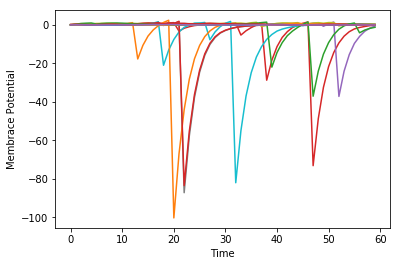

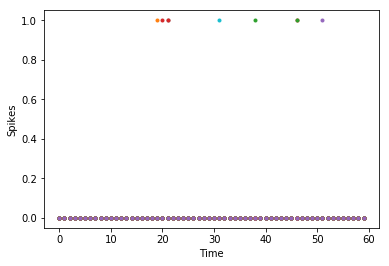

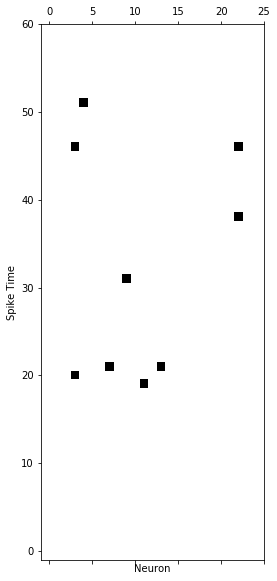

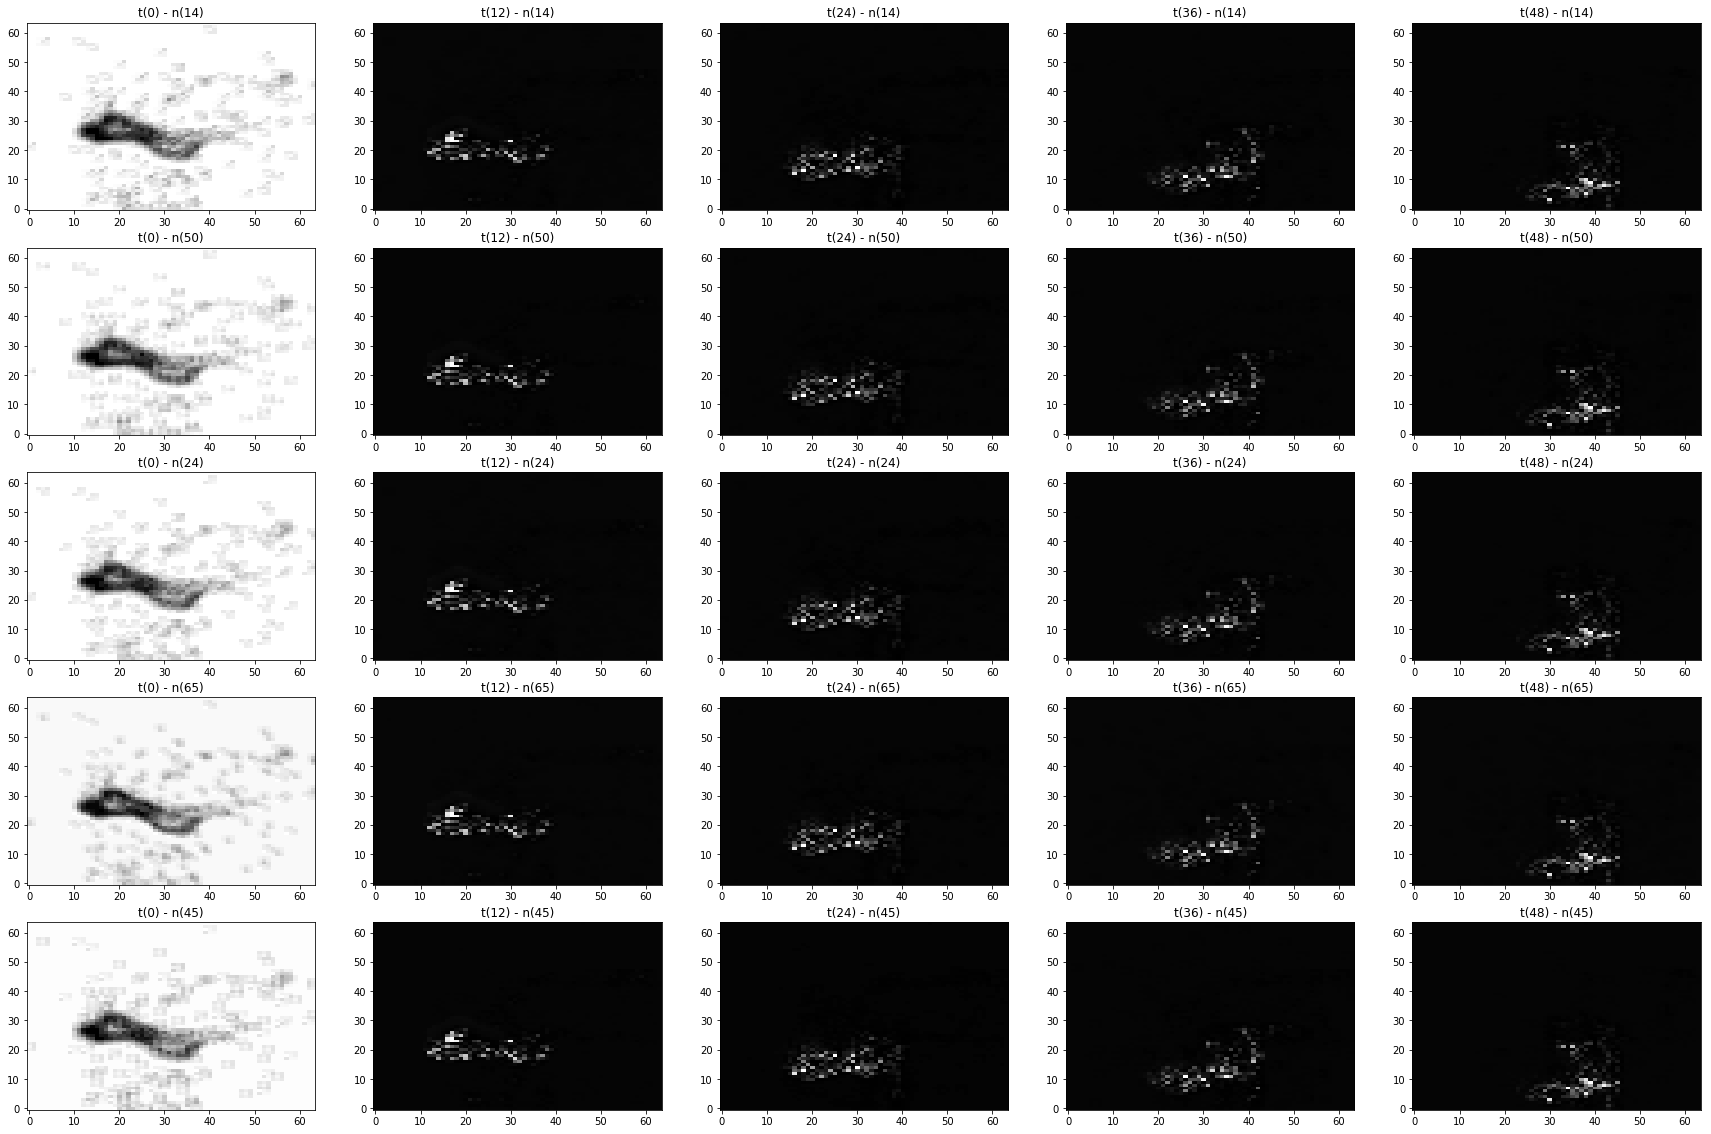

Layer 1: average number of spikes=0.0192
Layer 2: average number of spikes=0.1381


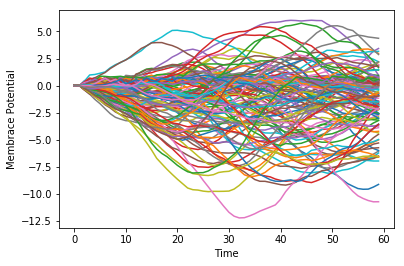

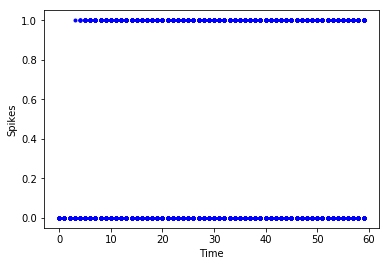

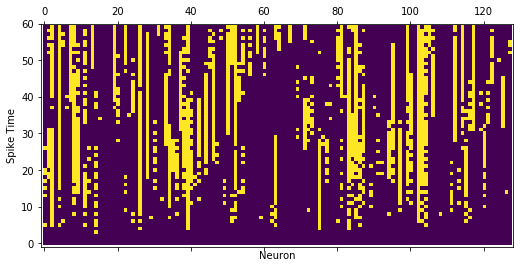

In [ ]:
for X_batch, _ in load_data('train'):
    break

network.predict(X_batch)

for i,l in enumerate(network.layers):
    if 'spk_rec_hist' in l.__dict__:
        print("Layer {}: average number of spikes={:.4f}".format(i, l.spk_rec_hist.mean()))
        if l.HAS_PARAM:
            plot_spikes_in_time(l)

In [ ]:
with open('results.log', 'w') as f:
    # opt = RAdam(network.get_trainable_parameters())
    opt = torch.optim.SGD(network.get_trainable_parameters(), lr=1e-3, momentum=0.9)
    network.fit(load_data, epochs=nb_epochs, optimizer=opt, dataset_size=dataset_size, result_file=f)

network.save('save_network.net')
# network.load('save_network.net')
    
print('\n----------------------------------------')
train_accuracy = network.compute_classification_accuracy(load_data('acc_train'))
print("Final Train Accuracy=%.2f%%"%(train_accuracy * 100.))
test_accuracy = network.compute_classification_accuracy(load_data('acc_test'))
print("Final Test Accuracy=%.2f%%"%(test_accuracy * 100.))

Epoch: 0 [>...........................................................] 0%    

In [ ]:
for X_batch, _ in load_data('train'):
    break

network.predict(X_batch)
for i,l in enumerate(network.layers):
    if 'spk_rec_hist' in l.__dict__:
        print("Layer {}: average number of spikes={:.4f}".format(i, l.spk_rec_hist.mean()))
        if l.HAS_PARAM:
            plot_spikes_in_time(l)

In [ ]:
# network.predict(X_batch)

# # Plotting spike trains or membrane potential
# for i,l in enumerate(network.layers):
#     if not l.HAS_PARAM or 'spk_rec_hist' not in l.__dict__:
#         continue
        
#     if isinstance(l, SpikingDenseLayer):
#         print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
#         spk_rec = l.spk_rec_hist
#         plot_spk_rec(spk_rec, idx=batch_idx)
#     elif isinstance(l, SpikingConv2DLayer):
#         print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
#         spk_rec = l.spk_rec_hist
#         plot_spk_rec(spk_rec.sum(1), idx=batch_idx)
#     else:
#         mem_rec = l.mem_rec_hist
#         plot_mem_rec(mem_rec, 0)